In [1]:
import pypsa 
#import atlite 
import vresutils.shapes as vshapes
from vresutils.graph import voronoi_partition_pts
import geopandas as gpd
import powerplantmatching as pm
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import geopandas as gpd

from pypsa.opt import Constraint as Con

import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr

In [1]:
import sys
sys.path

['/home/schlott/Vietnam/ReVietSys',
 '/home/schlott/anaconda3/lib/python37.zip',
 '/home/schlott/anaconda3/lib/python3.7',
 '/home/schlott/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/home/schlott/anaconda3/lib/python3.7/site-packages',
 '/home/schlott/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/schlott/.ipython']

In [3]:
!hostname

petunia


# Plots

## Devplan

### Connected - PHS - ERA5

In [4]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [5]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(4627.003798497612, 5986.923649034113, 14500.0)

In [6]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(11513.7297441, 18044.75917406, 20694.124673360002)

In [7]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

(0.009106534784089999, 0.0177854687859, 0.0269633598708)

In [8]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2020 - PHS')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2025 - PHS')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2030 - PHS')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_PHS/plots/devplan_all.pdf',
            bbox_inches='tight')

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

### Connected - NO PHS - ERA5

In [9]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [10]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(4627.003830690186, 5509.773007541367, 14515.2179851886)

In [11]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(11443.18878153, 18068.26500992, 20796.81162774)

In [12]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

(0.00912518563714, 0.017794664422000003, 0.0269878901538)

In [13]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data/plots/devplan_all.pdf',
            bbox_inches='tight')

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

### Connected - PHS - MERRA2

In [14]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [15]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(4627.003606883476, 5913.709018237235, 12149.909387799999)

In [16]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(11281.209991130001, 17917.022975260003, 20686.09025897)

In [17]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

(0.00904140754889, 0.017660699926399997, 0.026412357285100004)

In [18]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan2020 - PHS')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan2025 - PHS')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan2030 - PHS')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/plots/devplan_all.pdf',
            bbox_inches='tight')

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

### Connected - NO PHS - MERRA2

In [19]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [20]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(4627.003709636347, 5859.87305187968, 11295.98312521)

In [21]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(11235.7814936, 17886.81832256, 20802.164307139996)

In [ ]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

(0.00905982693323, 0.017668574542800002, 0.0264363947576)

In [ ]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_ninja-data/plots/devplan_all.pdf',
            bbox_inches='tight')

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

## Renewable

### Connected - PHS - ERA5

In [ ]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

In [ ]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

In [ ]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

In [ ]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

In [ ]:
bus_scale = 1e4
link_scale = 1e3

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2020 - PHS')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2025 - PHS')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2030 - PHS')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_PHS/plots/renewable_all.pdf',
            bbox_inches='tight')

### Connected - NO PHS - ERA5

In [ ]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

In [ ]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

In [ ]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

In [ ]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

In [ ]:
bus_scale = 1e4
link_scale = 1e3

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data/plots/renewable_all.pdf',
            bbox_inches='tight')

### Connected - PHS - MERRA2

In [ ]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

In [ ]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

In [ ]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

In [ ]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

In [ ]:
bus_scale = 1e4
link_scale = 1e3

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable2020 - PHS')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable2025 - PHS')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable2030 - PHS')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/plots/renewable_all.pdf',
            bbox_inches='tight')

### Connected - NO PHS - MERRA2

In [ ]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

In [ ]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

In [ ]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

In [ ]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

In [ ]:
bus_scale = 1e4
link_scale = 1e3

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable2020')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable2025')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable2030')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_ninja-data/plots/renewable_all.pdf',
            bbox_inches='tight')

# Costs

In [32]:
n3_dev.objective / 1e9

28.260744934799998

In [33]:
n3_ren.objective / 1e9

46.210323564800007

In [34]:
mar_generator = (n3_dev.generators['marginal_cost'] * n3_dev.generators_t.p).sum(axis=0).sum() / 1e9

cap_generator = (n3_dev.generators['capital_cost'] * n3_dev.generators.p_nom_opt).sum() / 1e9

mar_storage = (n3_dev.storage_units['marginal_cost'] * n3_dev.storage_units_t.p).sum(axis=0).sum() / 1e9

cap_storage = (n3_dev.storage_units['capital_cost'] * n3_dev.storage_units.p_nom_opt).sum() / 1e9

cap_lines = (n3_dev.lines['capital_cost'] * n3_dev.lines['length'] * n3_dev.lines['s_nom_opt'] / 1e3).sum() / 1e9
# From KW -> MW

mar_generator + cap_generator + mar_storage + cap_storage + cap_lines

35.508490422364055

In [35]:
mar_generator = (n3_ren.generators['marginal_cost'] * n3_ren.generators_t.p).sum(axis=0).sum() / 1e9

cap_generator = (n3_ren.generators['capital_cost'] * n3_ren.generators.p_nom_opt).sum() / 1e9

mar_storage = (n3_ren.storage_units['marginal_cost'] * n3_ren.storage_units_t.p).sum(axis=0).sum() / 1e9

cap_storage = (n3_ren.storage_units['capital_cost'] * n3_ren.storage_units.p_nom_opt).sum() / 1e9

#cap_links = (n3_ren.links['capital_cost'] * n3_ren.links['length'] * n3_ren.links['p_nom_opt'] / 1e3).sum() / 1e9
# From KW -> MW

cap_lines = (n3_ren.lines['capital_cost'] * n3_ren.lines['length'] * n3_ren.lines['s_nom_opt'] / 1e3).sum() / 1e9
# From KW -> MW

mar_generator + cap_generator + mar_storage + cap_storage + cap_lines

53.346888460617492

# Storage

## ERA5: Devplan + Storage

In [39]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/devplan_2020_storage/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/devplan_2025_storage/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/devplan_2030_storage/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [40]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(4627.0038306901861, 5491.9448188847846, 14547.983553373)

In [41]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(11443.18878325, 18068.265012190001, 20796.811627760002)

In [42]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

(0.00912518563717, 0.017794664421899999, 0.026987890153800001)

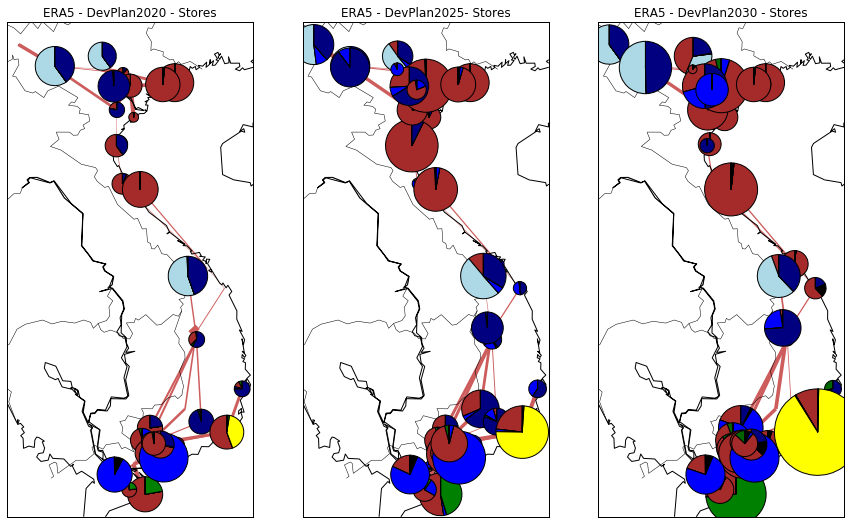

In [48]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum',
                   'battery', 'hydrogen', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink',
                   'gold', 'red', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2020 - Stores')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2025- Stores')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2030 - Stores')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_storage/plots/devplan_all.pdf',
            bbox_inches='tight')

## ERA5: Renewable + Storage

In [4]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/renewable_2020_storage/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/renewable_2025_storage/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/renewable_2030_storage/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [5]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(56548.056070256003, 78277.147961428986, 97559.546997672995)

In [6]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(30786.964424999998, 38119.412239700003, 46456.071580600001)

In [7]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

(0.0180703553719, 0.029572598313499999, 0.045371993668899997)

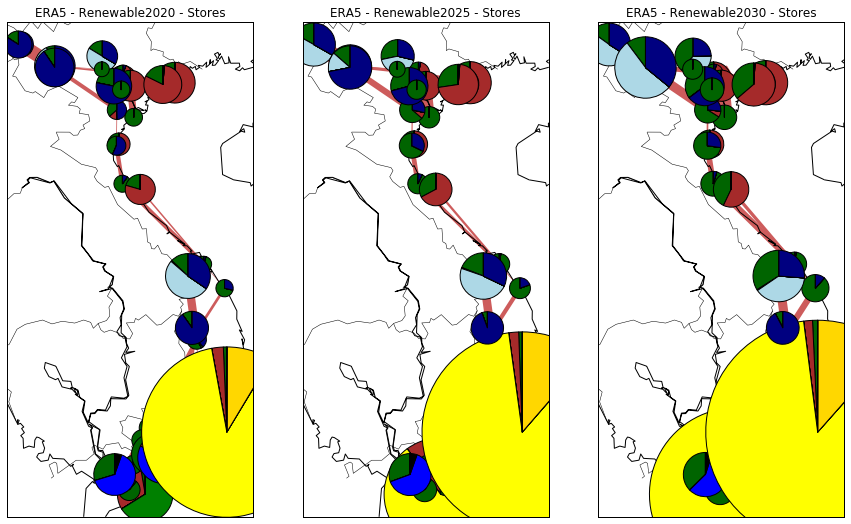

In [9]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum',
                   'battery', 'hydrogen', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink',
                   'gold', 'red', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes = axes.flatten()
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=axes[0],
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2020 - Stores')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=axes[1],
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2025 - Stores')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=axes[2],
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable2030 - Stores')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_era5-data_storage/plots/renewable_all.pdf',
            bbox_inches='tight')

## MERRA2: Devplan + Storage

In [ ]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_storage/devplan_2020_storage/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_storage/devplan_2025_storage/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_storage/devplan_2030_storage/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

In [ ]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

In [ ]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

In [ ]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

In [ ]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum',
                   'battery', 'hydrogen', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink',
                   'gold', 'red', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2020 - Stores')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2025- Stores')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan2030 - Stores')


fig.savefig(filename='/home/vres/data/ReVietSys/fias-model_ninja-data_storage/plots/devplan_all.pdf',
            bbox_inches='tight')

## MERRA5: Renewable + Storage

# N/A